In [117]:
import numpy as np
from scipy.stats import binom
from scipy.stats import truncnorm
from scipy.stats import gamma
from scipy.special import factorial

In [118]:
# Parameters 

h = 1/7
pho = 2/3
g = 2/3
R = 19
T = 7*R

In [119]:
def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [120]:
def K(k, betas):
    K = np.zeros((4,4))
    K[0, 0], K[0, 1], K[1, 1], K[1, 2], K[2, 2], K[2, 3], K[3, 3] = np.exp(-betas[k]*h), 1-np.exp(-betas[k]*h), np.exp(-h*pho), 1-np.exp(-h*pho), np.exp(-h*g), 1-np.exp(-h*g), 1
    return(K)

In [121]:
def calcul(Y, G, P, Q):
    Q_new = Q
    for s in np.argwhere(Q == 0):
        if Y[s[0]][s[1]]==0 or G[s[0]][s[1]]==0 or P[s[0]][s[1]]==0:
             Q_new[s[0]][s[1]] = 1
    M = np.multiply(Y, np.multiply(G, np.divide(P, Q)))
    for s in np.argwhere(Q == 0):
        M[s[0]][s[1]] = 0
    return M

In [122]:
def log_factorial(Y):
    M = np.zeros((4,4))
    M[1][2] = np.sum(np.log(np.arange(1, Y[1][2])))
    return M

In [123]:
# Initial settings
X1 = np.array([948, 0, 1, 0])
X2 = np.array([1689, 0, 1, 0])
X3 = np.array([3466, 0, 1, 0])
X4 = np.array([1894, 0, 1, 0])

def PAL(y, theta, R=19):
    X = np.array([X1, X2, X3, X4]) 
    X_all = np.array([X for r in range(R+1)])
    B = theta[:16].reshape(4,4)
    L = np.zeros((R, 4))
    for r in range(R):
        G = np.zeros((7, 4, 4, 4))
        for i in range(6):
            I =  X[:, 2]   
            betas = 1/8000 * np.dot(B, I)
            for k in range(4):
                G[i][k] = np.multiply(np.outer(np.ones(4), X[k]), K(k, betas))
                X[k] = np.transpose(np.dot(np.transpose(np.ones(4)), G[i][k]))
        I =  X[:, 2]   
        betas = 1/8000 * np.dot(B, I)
        for k in range(4):
            G[6][k] = np.multiply(np.outer(np.ones(4), X[k]), K(k, betas))
            M = np.zeros((4,4))
            Q = np.zeros((4,4))
            Q[1][2] = theta[k+16]
            for i in range(7):
                M = M + np.multiply(G[i][k], Q)
            Y_bar = np.zeros((4,4))
            Y_bar[1][2] = y[r][k]
            G_bar = np.multiply(np.outer(np.ones(4), np.ones(4))-Q, G[i][k]) + calcul(Y_bar, G[6][k], Q, M)
            X[k] = np.transpose(np.dot(np.transpose(np.ones(4)), G_bar))
            L[r][k] = -np.dot(np.transpose(np.ones(4)), np.dot(M, np.ones(4))) + np.dot(np.transpose(np.ones(4)), np.dot(np.multiply(Y_bar, np.log(M)), np.ones(4))) - np.dot(np.transpose(np.ones(4)), np.dot(log_factorial(Y_bar), np.ones(4)))
    return L

In [185]:
theta = np.concatenate((np.random.gamma(5, 1, 16), get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)), axis=None)
Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])
PAL(Y, theta, R=19)

array([[ -15.57892956,  -15.26820996,  -16.79046661,  -16.11499814],
       [ -16.        ,  -16.        ,  -29.50622089,  -16.11499814],
       [ -16.        ,  -16.        ,  -23.3391836 ,  -16.63617496],
       [ -64.47118135, -254.97838956, -311.9671037 ,  -36.43117896],
       [-212.86618167, -916.45849071, -627.90357902, -119.45749775],
       [-254.97838956, -911.12577192, -401.57571341,  -41.95065119],
       [-225.34258675, -616.00947056, -242.71748777,  -15.04760646],
       [ -74.00360522, -122.63176026,  -93.87529753,  -37.16711649],
       [ -46.67186011,  -49.50507345,  -19.8719228 ,  -15.69671452],
       [ -16.69314718,  -17.79175947,  -15.30819543,  -15.24453362],
       [ -16.        ,  -20.78749174,  -14.59649048,  -15.48526046],
       [ -16.        ,  -20.78749174,  -16.01199034,  -16.59502628],
       [ -16.        ,  -16.        ,  -19.78793401,  -15.20922562],
       [ -16.        ,  -16.        ,  -25.97234937,  -16.99229631],
       [ -16.        ,  -16.      

In [184]:
def log_PAL(y, theta, R=19):
    L = PAL(y, theta, R=19)
    for r in range(1, R):
        L[r] = np.sum(L[:r, :], axis=0)
    return L

In [130]:
theta = np.concatenate((np.random.gamma(5, 1, 16), truncnorm.rvs(a=0, b=1, loc=0.5, scale=0.5, size=4)), axis=None)
Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])
log_PAL(Y, theta, R=19)

array([[-1.56159578e+01, -1.55903314e+01, -1.63243607e+01,
        -1.63061035e+01],
       [-1.56159578e+01, -1.55903314e+01, -1.63243607e+01,
        -1.63061035e+01],
       [-3.12319156e+01, -3.11806629e+01, -3.26487213e+01,
        -3.26122069e+01],
       [-6.24638312e+01, -6.23613258e+01, -6.52974426e+01,
        -6.52244138e+01],
       [-1.24927662e+02, -1.24722652e+02, -1.30594885e+02,
        -1.30448828e+02],
       [-2.49855325e+02, -2.49445303e+02, -2.61189771e+02,
        -2.60897655e+02],
       [-4.99710649e+02, -4.98890606e+02, -5.22379541e+02,
        -5.21795311e+02],
       [-9.99421299e+02, -9.97781212e+02, -1.04475908e+03,
        -1.04359062e+03],
       [-1.99884260e+03, -1.99556242e+03, -2.08951816e+03,
        -2.08718124e+03],
       [-3.99768519e+03, -3.99112485e+03, -4.17903633e+03,
        -4.17436249e+03],
       [-7.99537039e+03, -7.98224970e+03, -8.35807266e+03,
        -8.34872497e+03],
       [-1.59907408e+04, -1.59644994e+04, -1.67161453e+04,
      

In [200]:
def log_prior(theta):
    prior = 1
    for i in range(16):
        prior = prior * gamma.pdf(theta[i], a=5, loc=0, scale=1)
    for i in range(4):
        prior = prior * truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5)
    if prior==0:
        return -100000
    else:
        return np.log(prior)

In [201]:
def logL(y, theta, R=19):
    L = np.zeros(4)
    for k in range(4):
        L[k] = np.sum(log_PAL(y, theta, R=19)[:, k], axis=0)
    return L+log_prior(theta)

In [197]:
def MCMC(y, N, R=19):                      # Metropolis-Hastings
    theta = np.concatenate((np.random.gamma(5, 1, 16), get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)), axis=None)    
    thetas = np.array([theta for i in range(N)])
    L = logL(y, theta, R=19)
    for n in range(1, N):
        theta_new =  np.concatenate((get_truncated_normal(mean=theta[:16], sd=0.2, low=0, upp=np.inf).rvs(), get_truncated_normal(mean=theta[16:], sd=0.2, low=0, upp=1).rvs()), axis=None)
        #print(theta_new)
        L_new = logL(y, theta_new, R=19) 
        v = L_new - L
        #print(L_new)
        for k in range(4):      
            u = np.random.uniform()
            #print(k, v[k])
            if np.log(u)<v[k]:
                L[k] = L_new[k]
                thetas[n][k:k+4] = theta_new[k:k+4]
                thetas[n][16+k] = theta_new[16+k]
                theta[k:k+4] = theta_new[k:k+4]
                theta[16+k] = theta_new[16+k]
            else:
                thetas[n][k:k+4] = theta[k:k+4]
                thetas[n][16+k] = theta[16+k]   
        #print(theta)
    return thetas

In [198]:
Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])
thetas = MCMC(Y, 1000, R=19)

In [173]:
thetas[5000:, 5]

array([6.30885601, 6.30885601, 6.30885601, ..., 6.17756181, 6.17756181,
       6.17756181], shape=(5000,))

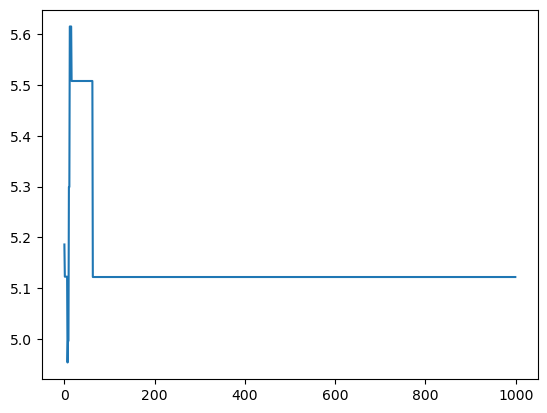

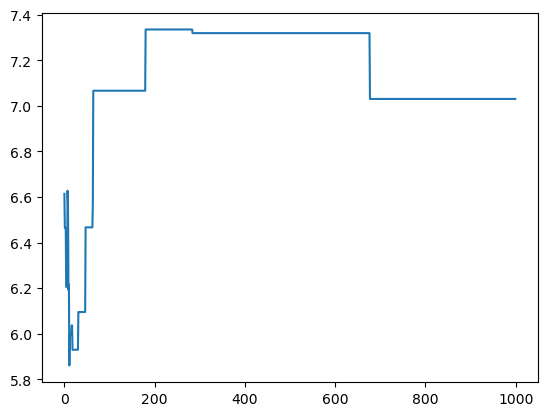

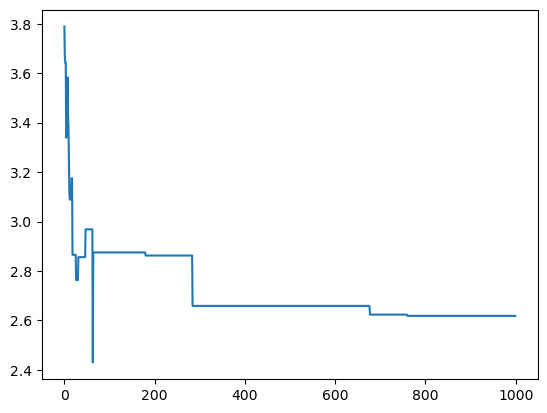

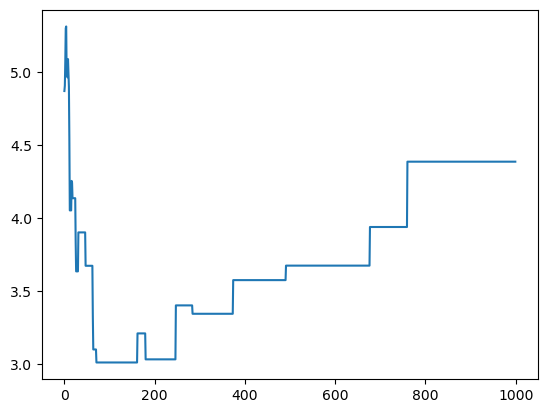

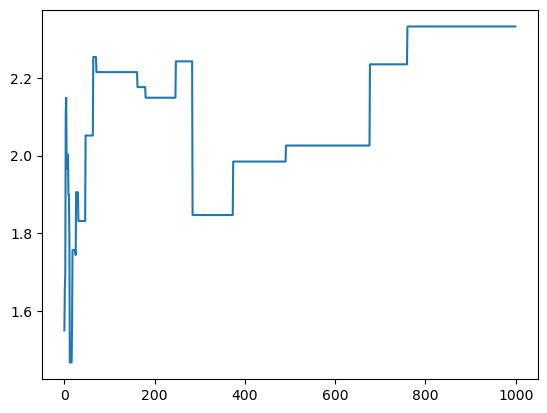

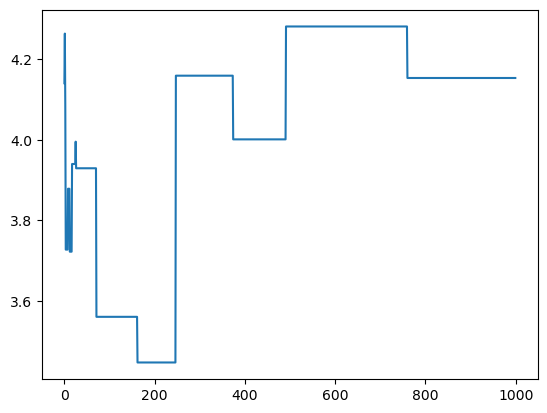

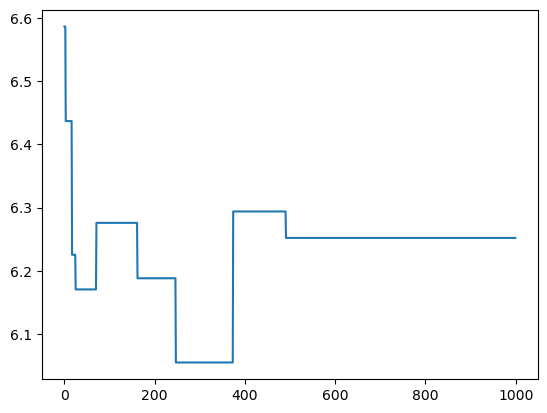

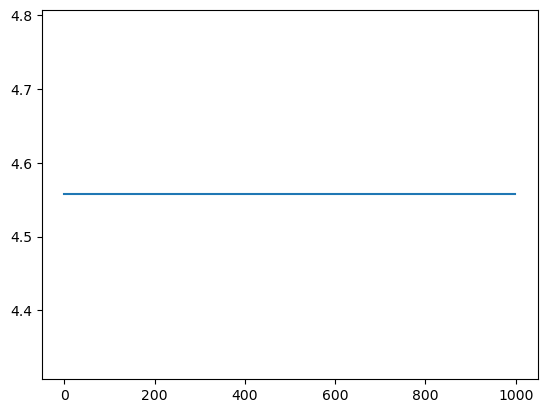

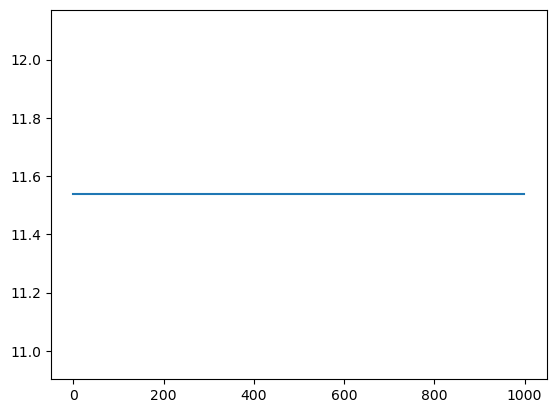

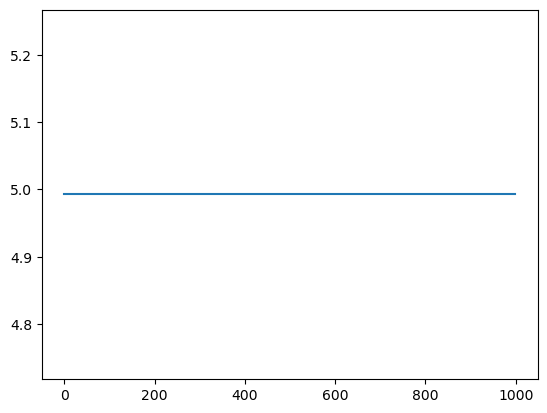

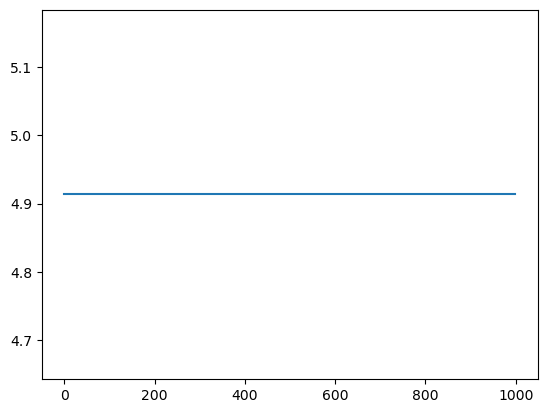

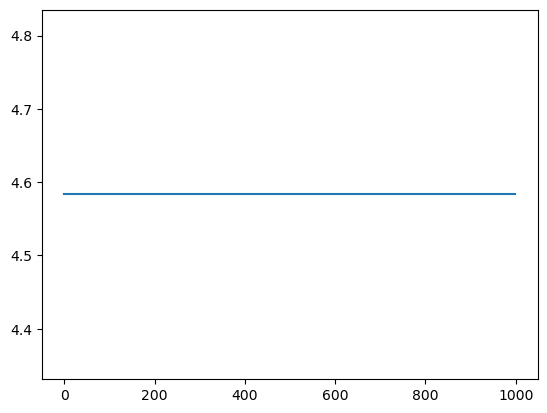

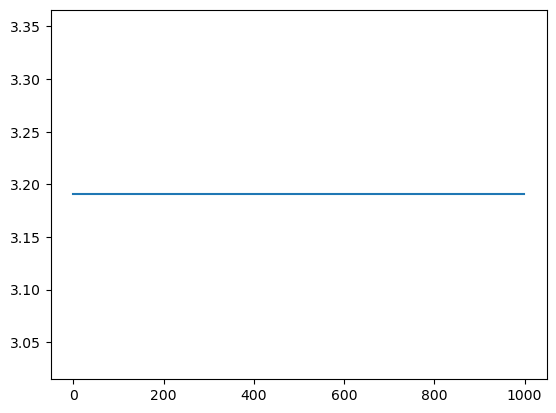

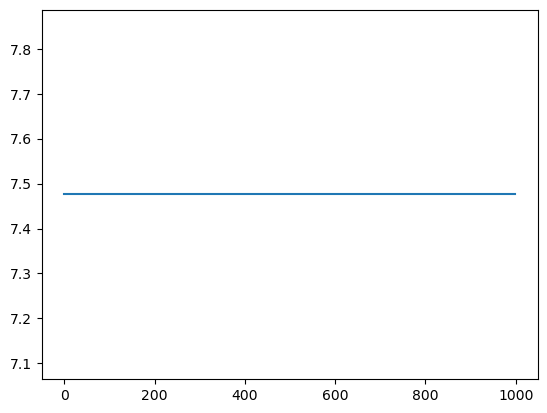

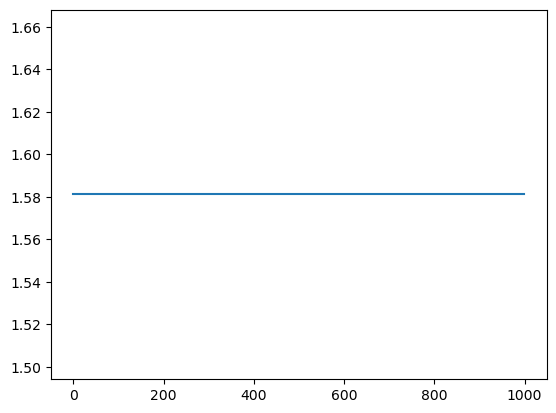

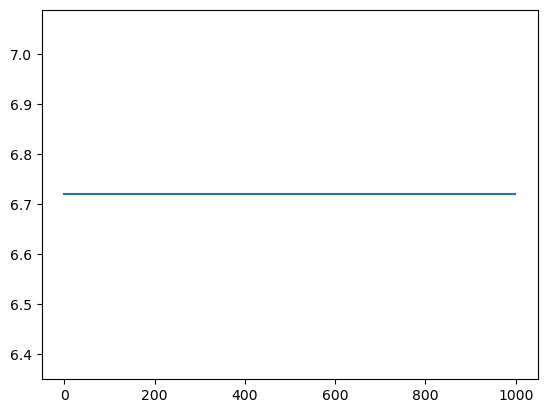

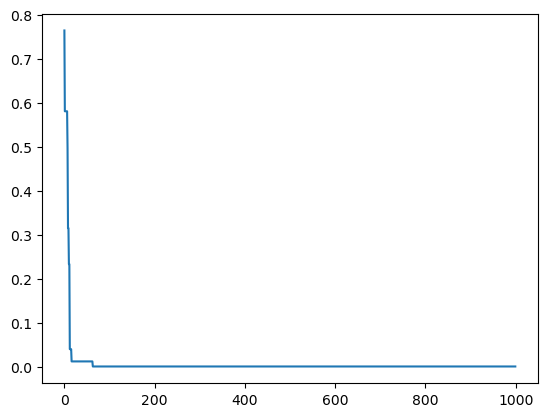

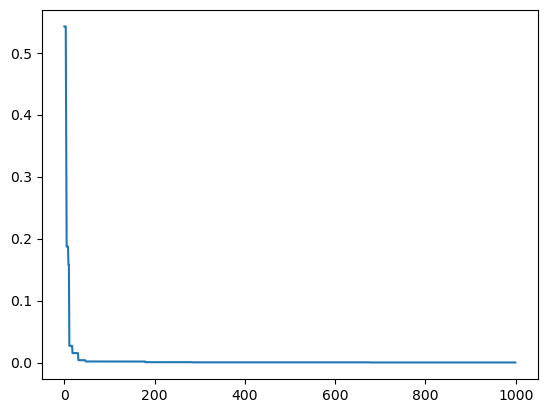

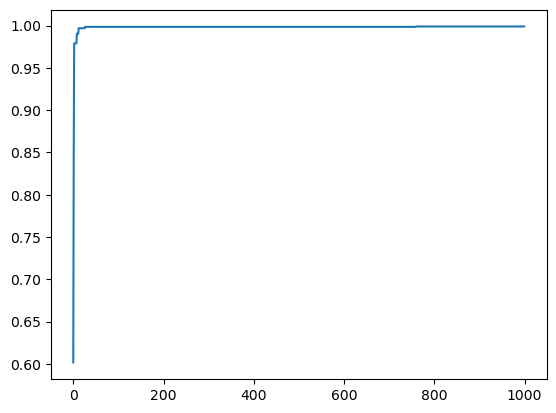

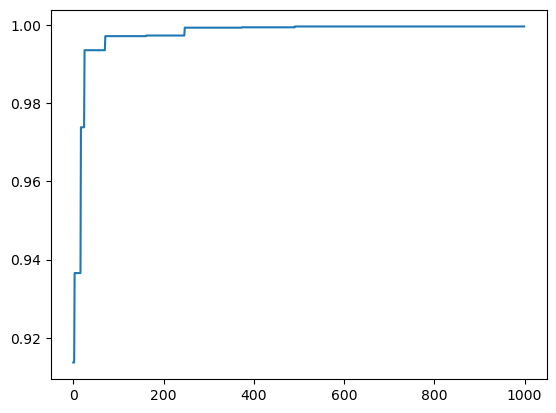

In [199]:
import matplotlib.pyplot as plt

for k in range(20):
    plt.plot(thetas[:, k])
    plt.show()

In [ ]:
theta_mean = np.sum(thetas[5000:])/5000

In [ ]:
n = np.array(949, 1700, 3467, 1985])
NGM = np.zeros((4,4))  #Next Generation Matrix
betas = theta_mean[:16].resahpe(4,4)
for i in in range(4):
    for j in range(4):
        NGM[i, j] = n[i]*betas[i,j]/8000*g
print(np.abs(np.linealg.eig(NGM)))